# Распознавание ключевых точек лица в реальном времени

## Импорт модулей

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import AdamW
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка данных

In [2]:
# Датасет: https://www.kaggle.com/competitions/facial-keypoints-detection/overview
train_val_df = pd.read_csv("training.csv")
train_val_df.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   
3          65.225739          37.261774           32.023096   
4          66.725301          39.621261           32.244810   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   
3           37.261774                60.003339                39.127179   
4           38.042032                58.565890                39.621261   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   
3                72.314713                38.380967                 37.618643   
4                72.515926                39.884466                 36.982380   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   
1                 34.361532  ...   55.660936            56.421447   
2                 36.320968  ...   53.538947            60.822947   
3                 38.754115  ...   54.166539            65.598887   
4                 39.094852  ...   64.889521            60.671411   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   
2            73.014316             33.726316             72.732000   
3            72.703722             37.245496             74.195478   
4            77.523239             31.191755             76.997301   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   
1               46.684596               70.266553                  45.467915   
2               47.274947               70.191789                  47.274947   
3               50.303165               70.091687                  51.561183   
4               44.962748               73.707387                  44.227141   

   mouth_center_bottom_lip_y  \
0                  84.485774   
1                  85.480170   
2                  78.659368   
3                  78.268383   
4                  86.871166   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  
1  219 215 204 196 204 211 212 200 180 168 178 19...  
2  144 142 159 180 188 188 184 180 167 132 84 59 ...  
3  193 192 193 194 194 194 193 192 168 111 50 12 ...  
4  147 148 160 196 215 214 216 217 219 220 206 18...  

[5 rows x 31 columns]

In [3]:
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

Проверка и удаление дубликатов.

In [4]:
train_val_df.duplicated(subset="Image").sum()

555

In [5]:
train_val_df.drop_duplicates(subset="Image", inplace=True)
train_val_df.duplicated(subset="Image").sum()

0

Проверка и удаление пустых значений.

In [6]:
train_val_df.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4224
left_eye_inner_corner_y      4224
left_eye_outer_corner_x      4228
left_eye_outer_corner_y      4228
right_eye_inner_corner_x     4227
right_eye_inner_corner_y     4227
right_eye_outer_corner_x     4226
right_eye_outer_corner_y     4226
left_eyebrow_inner_end_x     4225
left_eyebrow_inner_end_y     4225
left_eyebrow_outer_end_x     4270
left_eyebrow_outer_end_y     4270
right_eyebrow_inner_end_x    4225
right_eyebrow_inner_end_y    4225
right_eyebrow_outer_end_x    4258
right_eyebrow_outer_end_y    4258
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4226
mouth_left_corner_y          4226
mouth_right_corner_x         4225
mouth_right_corner_y         4225
mouth_center_top_lip_x       4220
mouth_center_top_lip_y       4220
mouth_center_bottom_lip_x      33
mouth_center_b

In [7]:
train_val_df.dropna(inplace=True)
train_val_df.isna().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [8]:
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, random_state=777, shuffle=True
)
print(f"{train_df.shape=}", f"{val_df.shape=}")

train_df.shape=(1712, 31) val_df.shape=(428, 31)


Фиксирование случайных значений.

In [9]:
def set_seed(seed=777, strict=False):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if strict:
        if hasattr(torch, "use_deterministic_algorithms"):
            torch.use_deterministic_algorithms(True)
        print("Strict deterministic behavior enabled.")
    else:
        if hasattr(torch, "use_deterministic_algorithms"):
            torch.use_deterministic_algorithms(False)
        print("Strict deterministic behavior disabled.")

    print(f"Seed fixed: {seed}")


set_seed(777)

Strict deterministic behavior disabled.
Seed fixed: 777


Загрузчик данных.

In [10]:
class KeypointsDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

        self.images = []
        self.keypoints = []

        for _, row in self.df.iterrows():
            image = row["Image"]
            image = np.fromstring(image, sep=" ").reshape([96, 96])
            image = np.stack((image, image, image), axis=-1)  # [H, W, C]
            image = image.astype(np.float32) / 255.0

            keypoints = row.drop(["Image"]).to_numpy().astype("float32")
            keypoints = keypoints.reshape(-1, 2)  # Преобразуем в список (x, y)

            self.images.append(image)
            self.keypoints.append(keypoints)

    def __getitem__(self, idx):
        image = self.images[idx]
        keypoints = self.keypoints[idx]

        if self.transforms:
            augmented = self.transforms(image=image, keypoints=keypoints)
            image = augmented["image"]
            keypoints = augmented["keypoints"]

        keypoints = (
            np.array(keypoints).flatten().astype(np.float32)
        )  # назад в flat для модели

        return {"image": image, "keypoints": keypoints}

    def __len__(self):
        return len(self.df)


train_transforms = A.Compose(
    [
        A.Resize(224, 224, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.Affine(
            scale=(0.9, 1.1), translate_percent=(-0.05, 0.05), rotate=(-15, 15), p=0.7
        ),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

val_transforms = A.Compose(
    [A.Resize(224, 224, p=1.0), A.Normalize(mean=(0.5,), std=(0.5,)), ToTensorV2()],
    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

In [11]:
train_dataset = KeypointsDataset(train_df, transforms=train_transforms)
val_dataset = KeypointsDataset(val_df, transforms=val_transforms)

Демострация изображения из датасета вместе с ключевыми точками.

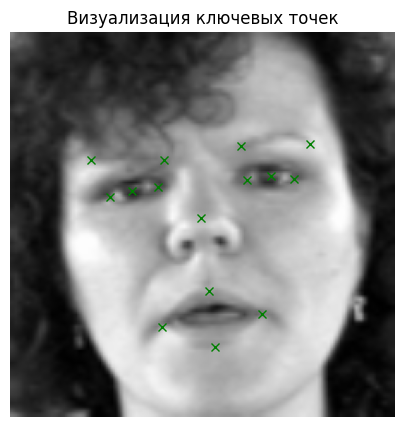

In [12]:
# Получаем элемент из датасета
datapoint = val_dataset[0]

# Изображение: [C, H, W] -> [H, W, C]
img = datapoint["image"].numpy().transpose(1, 2, 0)

# Обратная нормализация
img = img * 0.5 + 0.5  # возвращаем пиксели в [0, 1]
img = img * 255  # возвращаем пиксели в [0, 255]

# Ключевые точки: [x1, y1, x2, y2, ..., xN, yN]
keypoints = datapoint["keypoints"]
x_coords = keypoints[0::2]
y_coords = keypoints[1::2]

# Отображение
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap="gray")
plt.plot(x_coords, y_coords, "gx")
plt.title("Визуализация ключевых точек")
plt.axis("off")
plt.show()

## Обучение модели

In [13]:
# Функции для обучения и валидации
def train_one_epoch(model, loader, criterion, optimizer, device=torch.device("cuda")):
    model.train()
    epoch_loss = 0

    for batch in loader:
        data = batch["image"].to(device)
        target = batch["keypoints"].to(device)

        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(loader)
    return epoch_loss


def validate(model, loader, criterion, device=torch.device("cuda")):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in loader:
            data = batch["image"].to(device)
            target = batch["keypoints"].to(device)

            output = model(data)
            val_loss += criterion(output, target).item()

    val_loss = val_loss / len(loader)
    return val_loss


def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=10,
    device=torch.device("cuda"),
):
    train_losses = []
    val_losses = []

    best_loss = float("inf")
    best_model = None

    progress_bar = tqdm(range(1, epochs + 1), desc="Training", leave=True, total=epochs)

    for epoch in progress_bar:
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

        progress_bar.set_postfix(
            {
                "Epoch": epoch,
                "Train Loss": f"{train_loss:.4f}",
                "Val Loss": f"{val_loss:.4f}",
            }
        )

    result = {
        "best_model": best_model,
        "last_model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    print("Done!")
    return result

In [14]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(weights="DEFAULT")
model.fc = torch.nn.Linear(model.fc.in_features, 30)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=0.001)

results = train(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    epochs=20,
    device=device,
)

torch.save(results["best_model"], "keypoints_model.pth")

Training: 100%|██████████| 20/20 [02:01<00:00,  6.07s/it, Epoch=20, Train Loss=428.4597, Val Loss=766.2250] 

Done!


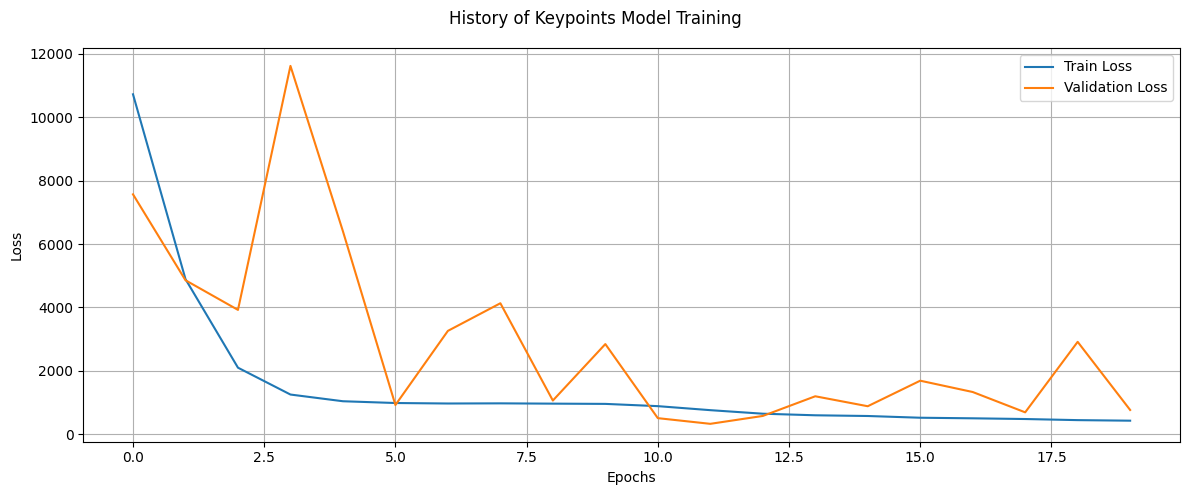

In [15]:
# Функция для визуализации результатов
def show_results(results, title=""):
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.plot(results["train_losses"], label="Train Loss")
    ax.plot(results["val_losses"], label="Validation Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


show_results(results, title="History of Keypoints Model Training")

## Обнаружение ключевых точек лица в реальном времени

In [ ]:
import torch
from torchvision import transforms as T
import cv2


# Преобразование: Grayscale → 3 канала → Тензор
transform = T.Compose(
    [
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.Grayscale(num_output_channels=1),
        T.Lambda(lambda img: img.convert("RGB")),  # дублируем в 3 канала
        T.ToTensor(),
        T.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)

# Детектор лиц
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


def run_inference_video(model, draw_face_box=True):
    cap = cv2.VideoCapture(0)

    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(
                gray_frame, scaleFactor=1.1, minNeighbors=5
            )

            for x, y, w, h in faces:
                face = frame[y : y + h, x : x + w]
                face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                face_input = transform(face_gray).unsqueeze(0)  # [1, 3, 224, 224]
                face_input = face_input.to(device)

                keypoints = model(face_input).view(-1, 2).cpu().numpy()

                # Масштабирование координат под исходное лицо
                scale_x = w / 224
                scale_y = h / 224

                for kx, ky in keypoints:
                    cx = int(kx * scale_x) + x
                    cy = int(ky * scale_y) + y
                    cv2.circle(frame, (cx, cy), 4, (0, 255, 0), -1)  # ключевые точки

                if draw_face_box:
                    cv2.rectangle(
                        frame, (x, y), (x + w, y + h), (0, 255, 0), 2
                    )  # рамка

            cv2.imshow("Facial Keypoints", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

    cap.release()
    cv2.destroyAllWindows()


# В качестве модели можно использовать только что сохраненную ("keypoints_model.pth")
# Или же обученную ранее в течение 500 эпох ("keypoints_model_500epochs.pth")
model = torch.load("keypoints_model_500epochs.pth", weights_only=False)
model = model.to(device)
model.eval()
run_inference_video(model, draw_face_box=True)

## Демонстрация работы алгоритма (запись)

In [16]:
from IPython.display import Video


Video("demo.mp4", width=640, height=480, embed=True)